In [87]:
# data manipulation
import pandas as pd
import numpy as np

# pre processing
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

# model
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

# plotting
import matplotlib.pyplot as plt

# saving
import joblib

In [88]:
X_train = joblib.load('data/X_train_preprocessed.pkl')
X_test = joblib.load('data/X_test_preprocessed.pkl')
y_train = joblib.load('data/y_train_preprocessed.pkl')
y_test = joblib.load('data/y_test_preprocessed.pkl')

In [89]:
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'f1_macro': make_scorer(f1_score, average='macro')
}

In [90]:
rf = RandomForestClassifier()
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [91]:
param_grid = {
    'n_estimators': [100, 200, 300, 500],          
    'max_depth': [None, 10, 20, 30, 50],             
    'min_samples_split': [2, 5, 10],                 
    'min_samples_leaf': [1, 2, 4],                   
    'max_features': [None, 'sqrt', 'log2'],        
    'bootstrap': [True, False],                      
    'criterion': ['gini', 'entropy']                 
}

In [97]:
def train_random_search(X, y, estimator, grid):
    random_search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=grid,
        cv=skf,
        scoring=scoring,
        refit='f1_macro',
        n_jobs=-1,
        return_train_score=True,
        verbose=1,
        n_iter=100
    )

    random_search.fit(X, y)

    return random_search

In [98]:
def get_results(r_search):
    results = pd.DataFrame(r_search.cv_results_)
    
    results = results[
        [
            'mean_fit_time', 'mean_score_time', 'param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf',
            'param_max_features', 'param_bootstrap', 'param_criterion', 'mean_train_accuracy', 'mean_test_accuracy', 'rank_test_accuracy', 
            'mean_train_precision_macro', 'mean_test_precision_macro', 'rank_test_precision_macro', 'mean_train_recall_macro', 
            'mean_test_recall_macro', 'rank_test_recall_macro', 'mean_train_f1_macro', 'mean_test_f1_macro', 'rank_test_f1_macro'
        ]
    ]

    results = results.sort_values(by='mean_test_f1_macro', ascending=False)
    return results

In [99]:
pd.set_option('display.max_columns', None)

In [100]:
grid_search = train_random_search(X_train, y_train, rf, param_grid)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [101]:
results = get_results(grid_search)

In [102]:
results.head(10)

,mean_fit_time,mean_score_time,param_n_estimators,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,param_bootstrap,param_criterion,mean_train_accuracy,mean_test_accuracy,rank_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,rank_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,rank_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro,rank_test_f1_macro
25,50.110043,0.069914,500,30,5,4,None,True,entropy,0.981905,0.866814,2,0.989290,0.795229,71,0.945169,0.648499,7,0.965585,0.683735,1
97,20.004236,0.032761,200,30,10,4,None,True,entropy,0.975235,0.867327,1,0.984974,0.797949,69,0.925341,0.647930,8,0.952108,0.683100,2
29,22.593060,0.035971,200,30,5,1,None,True,entropy,0.999905,0.864937,6,0.999943,0.785781,77,0.999713,0.647322,9,0.999828,0.681032,3
30,50.355391,0.070718,500,50,2,4,None,True,entropy,0.982322,0.865280,4,0.989369,0.788844,73,0.946573,0.645878,10,0.966430,0.679892,4
66,11.211990,0.022474,100,50,2,1,None,True,entropy,0.999981,0.864087,12,0.999989,0.785172,79,0.999942,0.645186,13,0.999966,0.678749,5
31,11.066979,0.023459,100,30,2,2,None,True,entropy,0.999261,0.863575,17,0.999558,0.780232,82,0.997757,0.645276,12,0.998655,0.678007,6
75,61.512356,0.076261,500,None,10,1,None,True,gini,0.979422,0.863234,21,0.987647,0.779062,83,0.937820,0.644664,15,0.960627,0.677446,7
1,32.759290,0.046425,300,20,2,4,None,True,entropy,0.982246,0.864256,11,0.989325,0.785222,78,0.946343,0.643591,16,0.966278,0.676829,8
4,54.247613,0.073705,500,20,2,4,None,True,gini,0.966784,0.865109,5,0.979648,0.790618,72,0.900107,0.642871,20,0.934318,0.676814,9
60,11.799781,0.023134,100,None,10,2,None,True,gini,0.968508,0.862381,30,0.980563,0.776037,85,0.905387,0.643338,18,0.938030,0.675855,10


In [121]:
def view_test_metrics(train_metrics: bool, filter_top_n: int, results_df: pd.DataFrame):
    if train_metrics:
        metrics = [
            "mean_train_accuracy", "mean_test_accuracy",
            "mean_train_precision_macro", "mean_test_precision_macro",
            "mean_train_recall_macro", "mean_test_recall_macro",
            "mean_train_f1_macro", "mean_test_f1_macro"
        ]
    else:
        metrics = [
            "mean_test_accuracy",
            "mean_test_precision_macro",
            "mean_test_recall_macro",
            "mean_test_f1_macro"
        ]

    if filter_top_n:
        results_df = results_df.nsmallest(filter_top_n, "rank_test_f1_macro")

    param_cols = [
        'param_n_estimators', 'param_max_depth', 'param_min_samples_split', 
        'param_min_samples_leaf', 'param_bootstrap', 'param_criterion'
    ]
    plot_df = results_df.melt(
        id_vars=param_cols,      # keep these columns "as is"
        value_vars=metrics,      # the columns we want to "unpivot"
        var_name="metric",       # new column with the metric name
        value_name="score"       # new column with the metric value
    )

    plt.figure(figsize=(12, 8))
    
    # Group the data by parameter combination and create a list of groups.
    groups = list(plot_df.groupby(param_cols))
    # Create a color palette with as many colors as there are groups.
    colors = plt.cm.tab10(np.linspace(0, 1, len(groups)))
    
    for i, (combo, group) in enumerate(groups):
        group = group.sort_values("metric")
        # Create a label for the model using its parameters.
        label_str = ", ".join(f"{col}={val}" for col, val in zip(param_cols, combo))
        # Pick the color for this group.
        color = colors[i]
        
        # Separate training and test metrics
        train_group = group[group["metric"].str.startswith("mean_train")]
        test_group = group[~group["metric"].str.startswith("mean_train")]
        
        # Plot training metrics with the same color
        if not train_group.empty:
            plt.plot(train_group["metric"], train_group["score"], 
                     marker='x', linestyle='dashed', alpha=0.7,
                     color=color,
                     label=label_str + " (train)")
        # Plot test metrics with the same color
        if not test_group.empty:
            plt.plot(test_group["metric"], test_group["score"], 
                     marker='o', linestyle='solid', alpha=0.7,
                     color=color,
                     label=label_str + " (test)")

    plt.xlabel("Metric")
    plt.ylabel("Score")
    plt.title("Comparison of Mean Test Metrics")
    plt.xticks(rotation=45)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()

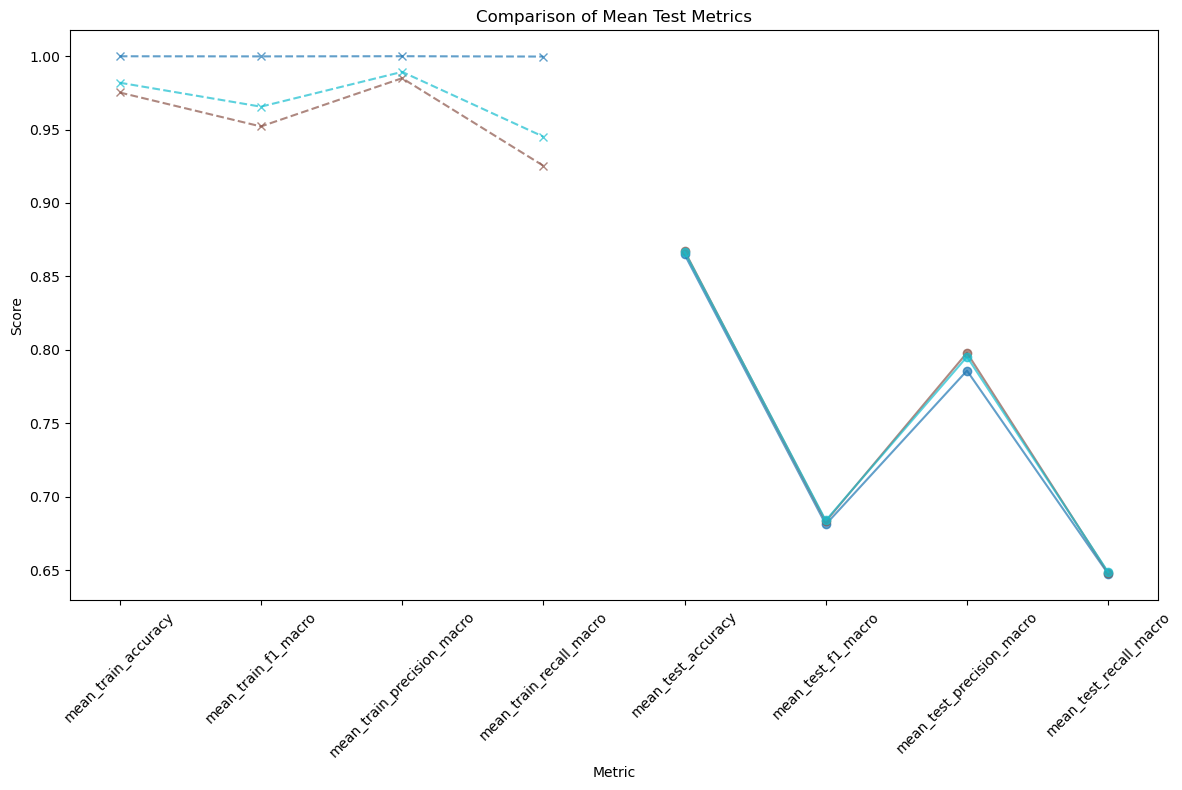

In [125]:
view_test_metrics(True, 3, results)

Como os modelos ficaram com recall e, consequentemente, f1-score baixo, isso indica que o modelo provavelmente está com bom desempenho para a classe dominante (ja que a acurácia está boa), mas não para a outra. Isso pode acontecer por conta do desbalanceamento entre as classes, então podemos tentar aplicar técnicas de balanceamento.

In [126]:
def os_smote(X, y):
    # auto faz resampling de todas as classes, menos a minoritária
    smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    
    return X_balanced, y_balanced

In [127]:
pipeline = Pipeline([
    ('oversampler', RandomOverSampler(sampling_strategy='auto', random_state=42)),
    ('rf', RandomForestClassifier())
])

In [128]:
param_grid = {
    'rf__n_estimators': [100, 200, 300, 500],          
    'rf__max_depth': [None, 10, 20, 30, 50],             
    'rf__min_samples_split': [2, 5, 10],                 
    'rf__min_samples_leaf': [1, 2, 4],                   
    'rf__max_features': [None, 'sqrt', 'log2'],        
    'rf__bootstrap': [True, False],                      
    'rf__criterion': ['gini', 'entropy'],
    'rf__random_state': [42]
}

In [137]:
def get_results_pipeline(r_search):
    results = pd.DataFrame(r_search.cv_results_)
    
    results = results[
        [
            'mean_fit_time', 'mean_score_time', 'param_rf__n_estimators', 'param_rf__max_depth', 'param_rf__min_samples_split', 'param_rf__min_samples_leaf',
            'param_rf__max_features', 'param_rf__bootstrap', 'param_rf__criterion', 'mean_train_accuracy', 'mean_test_accuracy', 'rank_test_accuracy', 
            'mean_train_precision_macro', 'mean_test_precision_macro', 'rank_test_precision_macro', 'mean_train_recall_macro', 
            'mean_test_recall_macro', 'rank_test_recall_macro', 'mean_train_f1_macro', 'mean_test_f1_macro', 'rank_test_f1_macro'
        ]
    ]

    results = results.sort_values(by='mean_test_f1_macro', ascending=False)
    return results

In [145]:
def view_test_metrics(train_metrics: bool, filter_top_n: int, results_df: pd.DataFrame):
    if train_metrics:
        metrics = [
            "mean_train_accuracy", "mean_test_accuracy",
            "mean_train_precision_macro", "mean_test_precision_macro",
            "mean_train_recall_macro", "mean_test_recall_macro",
            "mean_train_f1_macro", "mean_test_f1_macro"
        ]
    else:
        metrics = [
            "mean_test_accuracy",
            "mean_test_precision_macro",
            "mean_test_recall_macro",
            "mean_test_f1_macro"
        ]

    if filter_top_n:
        results_df = results_df.nsmallest(filter_top_n, "rank_test_f1_macro")

    param_cols = [
        'param_rf__n_estimators', 'param_rf__max_depth', 'param_rf__min_samples_split', 
        'param_rf__min_samples_leaf', 'param_rf__bootstrap', 'param_rf__criterion'
    ]
    plot_df = results_df.melt(
        id_vars=param_cols,      # keep these columns "as is"
        value_vars=metrics,      # the columns we want to "unpivot"
        var_name="metric",       # new column with the metric name
        value_name="score"       # new column with the metric value
    )

    plt.figure(figsize=(12, 8))
    
    # Group the data by parameter combination and create a list of groups.
    groups = list(plot_df.groupby(param_cols))
    # Create a color palette with as many colors as there are groups.
    colors = plt.cm.tab10(np.linspace(0, 1, len(groups)))
    
    for i, (combo, group) in enumerate(groups):
        group = group.sort_values("metric")
        # Create a label for the model using its parameters.
        label_str = ", ".join(f"{col}={val}" for col, val in zip(param_cols, combo))
        # Pick the color for this group.
        color = colors[i]
        
        # Separate training and test metrics
        train_group = group[group["metric"].str.startswith("mean_train")]
        test_group = group[~group["metric"].str.startswith("mean_train")]
        
        # Plot training metrics with the same color
        if not train_group.empty:
            plt.plot(train_group["metric"], train_group["score"], 
                     marker='x', linestyle='dashed', alpha=0.7,
                     color=color,
                     label=label_str + " (train)")
        # Plot test metrics with the same color
        if not test_group.empty:
            plt.plot(test_group["metric"], test_group["score"], 
                     marker='o', linestyle='solid', alpha=0.7,
                     color=color,
                     label=label_str + " (test)")

    plt.xlabel("Metric")
    plt.ylabel("Score")
    plt.title("Comparison of Mean Test Metrics")
    plt.xticks(rotation=45)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()

In [132]:
def train_random_search(X, y, estimator, grid):
    random_search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=grid,
        cv=skf,
        scoring=scoring,
        refit='f1_macro',
        n_jobs=-1,
        return_train_score=True,
        verbose=1,
        n_iter=20
    )

    random_search.fit(X, y)

    return random_search

In [ ]:
randomized_search = train_random_search(X_train, y_train, pipeline, param_grid)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


KeyError: "['rf__param_n_estimators', 'rf__param_max_depth', 'rf__param_min_samples_split', 'rf__param_min_samples_leaf', 'rf__param_max_features', 'rf__param_bootstrap', 'rf__param_criterion'] not in index"

In [138]:
results = get_results_pipeline(randomized_search)

In [139]:
results.head(10)

,mean_fit_time,mean_score_time,param_rf__n_estimators,param_rf__max_depth,param_rf__min_samples_split,param_rf__min_samples_leaf,param_rf__max_features,param_rf__bootstrap,param_rf__criterion,mean_train_accuracy,mean_test_accuracy,rank_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,rank_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,rank_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro,rank_test_f1_macro
8,8.833943,0.085889,500,50,2,4,log2,True,entropy,0.994221,0.862895,7,0.986116,0.753361,11,0.993124,0.718027,4,0.989577,0.732703,1
5,2.083498,0.030616,100,20,2,4,log2,True,entropy,0.993255,0.860508,9,0.983575,0.748102,12,0.992269,0.720323,3,0.987856,0.732123,2
15,5.024017,0.057266,300,50,5,4,log2,True,gini,0.990962,0.857950,13,0.977657,0.742774,13,0.990204,0.717135,5,0.983794,0.728099,3
19,3.351343,0.039363,200,None,5,4,log2,True,gini,0.990867,0.856758,14,0.977191,0.740730,14,0.990378,0.713517,6,0.983635,0.725113,4
18,5.406490,0.057570,300,None,10,2,log2,True,gini,0.996021,0.863580,6,0.991265,0.757681,10,0.994340,0.702255,7,0.992794,0.723675,5
9,5.523017,0.046860,200,30,5,2,sqrt,True,entropy,0.999318,0.865623,1,0.999453,0.765286,9,0.998068,0.691856,10,0.998758,0.718087,6
4,5.236500,0.037822,200,10,10,1,sqrt,False,entropy,0.922313,0.821969,16,0.840148,0.698030,16,0.950911,0.752116,1,0.879847,0.717192,7
12,2.017282,0.023879,100,10,2,4,sqrt,True,gini,0.912176,0.814296,17,0.826115,0.691254,17,0.938794,0.751683,2,0.865379,0.711110,8
11,67.891376,0.052263,300,20,2,1,None,True,gini,0.997025,0.853685,15,0.991138,0.734407,15,0.998219,0.693005,9,0.994635,0.709428,9
0,9.940444,0.097159,500,20,2,1,log2,True,entropy,1.000000,0.864429,2,1.000000,0.771166,5,1.000000,0.668272,11,1.000000,0.699624,10


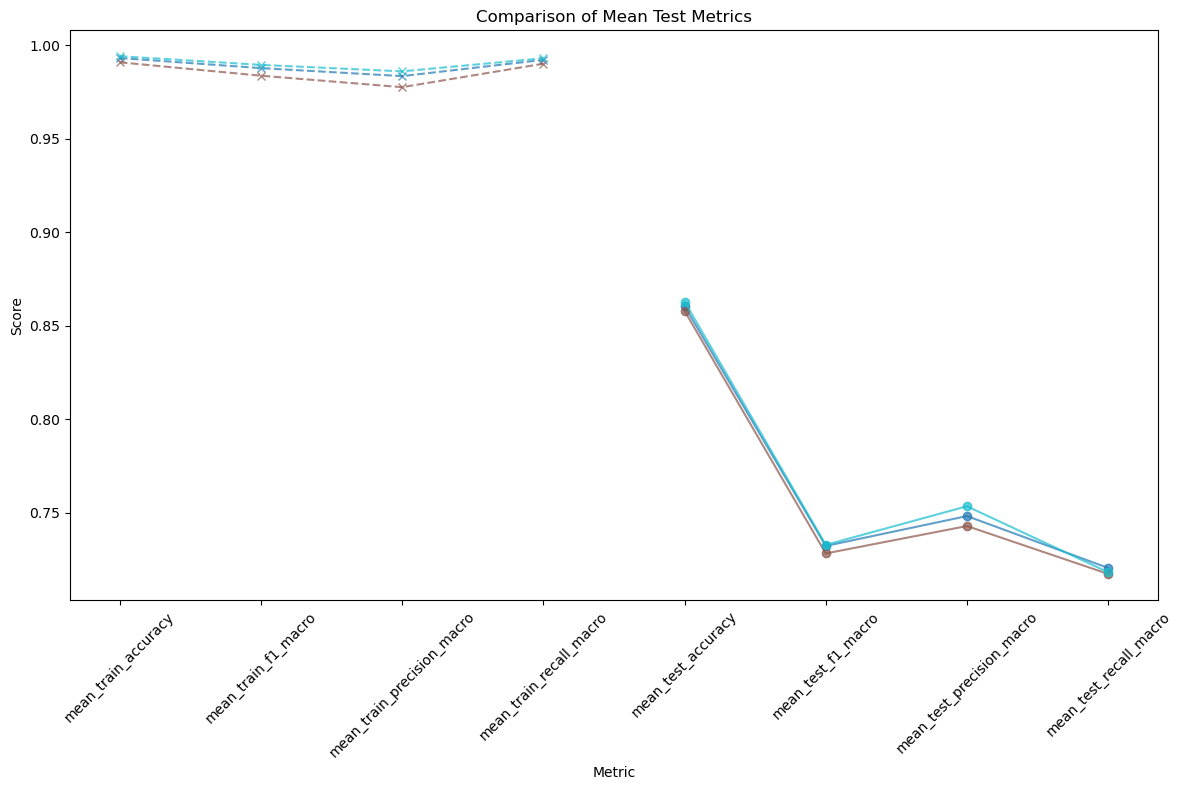

In [146]:
view_test_metrics(True, 3, results)

In [147]:
pipeline = Pipeline([
    ('oversampler', SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)),
    ('rf', RandomForestClassifier())
])

In [148]:
randomized_search = train_random_search(X_train, y_train, pipeline, param_grid)
results = get_results_pipeline(randomized_search)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


In [149]:
results.head(10)

,mean_fit_time,mean_score_time,param_rf__n_estimators,param_rf__max_depth,param_rf__min_samples_split,param_rf__min_samples_leaf,param_rf__max_features,param_rf__bootstrap,param_rf__criterion,mean_train_accuracy,mean_test_accuracy,rank_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,rank_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,rank_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro,rank_test_f1_macro
3,3.007069,0.023304,100,10,2,1,log2,False,gini,0.949504,0.845845,16,0.891633,0.720122,15,0.941379,0.716990,2,0.913850,0.718297,1
8,13.913946,0.075555,500,10,2,4,log2,True,entropy,0.914128,0.843287,18,0.839343,0.716650,18,0.858151,0.719189,1,0.848261,0.717601,2
6,13.274647,0.047288,300,10,5,4,sqrt,False,gini,0.933417,0.845675,17,0.871263,0.719324,17,0.896246,0.710637,3,0.883022,0.714467,3
7,4.597176,0.021965,100,10,5,1,sqrt,False,gini,0.946491,0.846184,15,0.889451,0.719540,16,0.929095,0.708866,4,0.907573,0.713682,4
9,7.824281,0.032670,200,10,5,2,sqrt,True,entropy,0.925894,0.841411,19,0.858398,0.711616,19,0.882785,0.705590,5,0.869855,0.708117,5
4,42.441313,0.022511,100,50,10,4,None,True,gini,0.962805,0.854369,14,0.953489,0.736024,14,0.908160,0.690038,6,0.928911,0.708012,6
0,116.556945,0.047213,300,20,5,4,None,True,entropy,0.985410,0.860508,9,0.988034,0.752766,10,0.958764,0.681294,7,0.972677,0.706337,7
13,13.307285,0.053595,300,None,5,1,sqrt,True,gini,0.998143,0.862385,4,0.998891,0.762242,6,0.994364,0.674118,8,0.996610,0.702832,8
5,10.152574,0.038565,200,50,2,1,sqrt,True,entropy,1.000000,0.863745,3,1.000000,0.766746,3,1.000000,0.671578,13,1.000000,0.701611,9
16,4.111477,0.023052,100,50,5,1,sqrt,True,gini,0.997442,0.861020,8,0.998380,0.757719,8,0.992328,0.671626,12,0.995322,0.699700,10


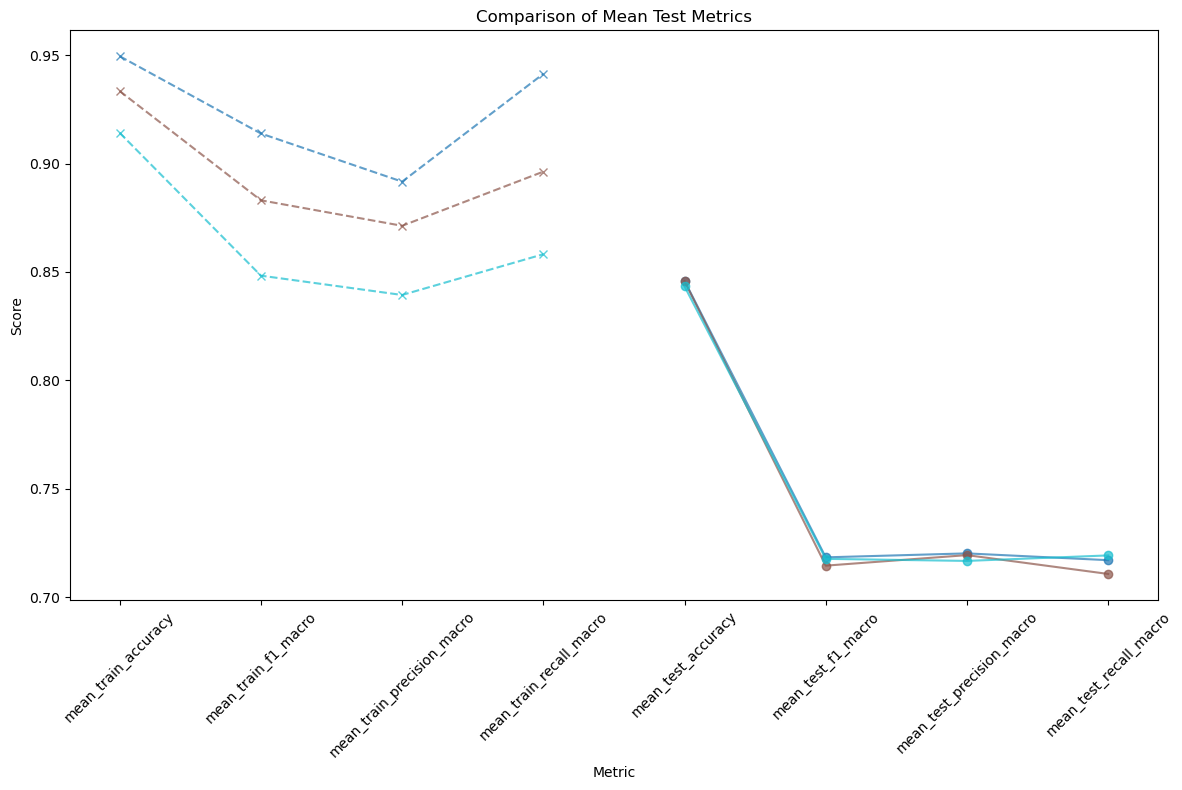

In [150]:
view_test_metrics(True, 3, results)

Retreinando o modelo com melhor configuração

In [153]:
pipeline = Pipeline([
    ('oversampler', RandomOverSampler(sampling_strategy='auto', random_state=42)),
    ('rf', RandomForestClassifier(
        n_estimators=500,
        max_depth=50,
        min_samples_split=2,
        min_samples_leaf=4,
        max_features='log2',
        bootstrap=True,
        criterion='entropy',
        random_state=42
    ))
])

In [154]:
preds = cross_val_predict(pipeline, X_train, y_train, cv=skf, n_jobs=-1)

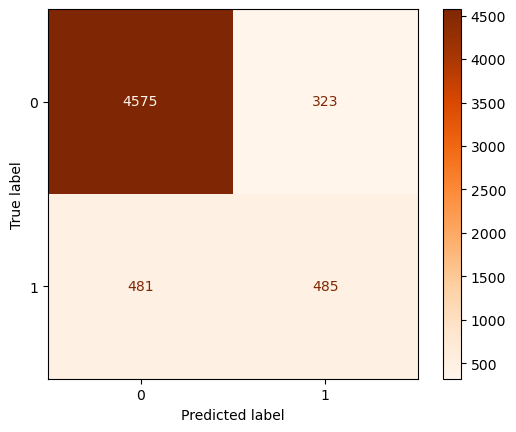

In [155]:
cm = confusion_matrix(y_train, preds)
cmd = ConfusionMatrixDisplay(cm, display_labels=grid_search.best_estimator_.classes_)
cmd.plot(cmap=plt.cm.Oranges)
plt.show()

In [156]:
print(classification_report(y_train, preds, digits=4))

              precision    recall  f1-score   support

           0     0.9049    0.9341    0.9192      4898
           1     0.6002    0.5021    0.5468       966

    accuracy                         0.8629      5864
   macro avg     0.7526    0.7181    0.7330      5864
weighted avg     0.8547    0.8629    0.8579      5864



In [157]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('oversampler', RandomOverSampler(random_state=42)),
                ('rf',
                 RandomForestClassifier(criterion='entropy', max_depth=50,
                                        max_features='log2', min_samples_leaf=4,
                                        n_estimators=500, random_state=42))])

In [158]:
rf = pipeline.named_steps['rf']

In [ ]:
col_names = list(joblib.load('data/col_names.pkl'))

In [165]:
len(col_names)

129

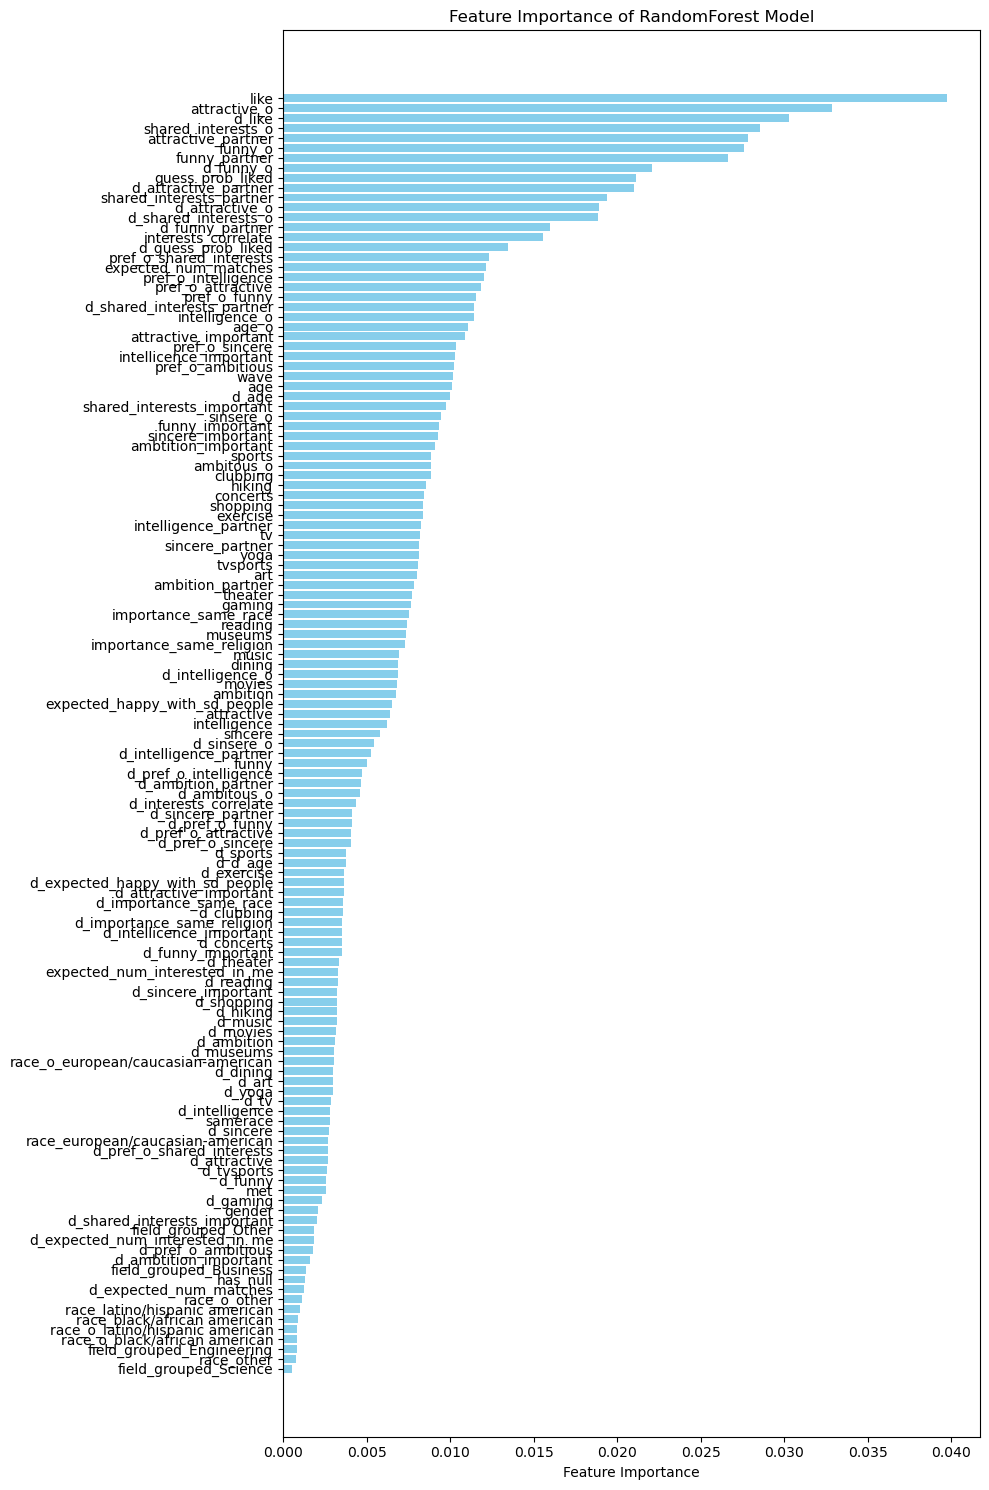

In [171]:
importances = rf.feature_importances_.ravel().reshape(1, -1)
feature_importance = pd.DataFrame(data=importances, columns=col_names)

importance_series = feature_importance.iloc[0]
importance_series_sorted = importance_series.sort_values(ascending=True)

plt.figure(figsize=(10, 15))
plt.barh(importance_series_sorted.index, importance_series_sorted.values, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance of RandomForest Model')
plt.tight_layout()
plt.show()

In [172]:
joblib.dump(rf, 'models/rf.pkl')

['models/rf.pkl']

- tempo de treinamento pode ser pego no gridsearch
- tempo de inferência pode ser calculado com time
```py
import time

start = time.time()
modelo.predict(X_test)
tempo_inferencia = time.time() - start
```
- uso de memória com
```py
from memory_profiler import memory_usage

def uso_de_memoria():
    modelo.predict(X_test)
    return modelo

mem_usage = memory_usage((treinar_modelo, ))
print(f"Memória máxima utilizada: {max(mem_usage)} MB")
```

- complexidade do modelo
`modelo.summary()` para redes neurais

para ver o tamanho
```py
import os
import joblib

joblib.dump(modelo, 'modelo.pkl')
tamanho = os.path.getsize('modelo.pkl')
print(f"Tamanho do modelo: {tamanho/1e6:.2f} MB")
```